## Experimentação de modelos
 Nesta sessão irei realizar uma série de experimentos, combinando diferentes modelos e preprocessamentos. Para registrar tudo isso, irei utilizar o MLFlow.

Aqui irei testar modelos baseados em distância e árvore, segue os esboços dos testes a serem realizados:

Baseados em estatística:
- Standard Scaler em todas as variáveis numéricas + One Hot Encoder em todas as categóricas.
- Standard Scaler em todas as variáveis numéricas + One Hot Encoder nas categóricas nominais + Ordinal Encoder nas ordinais.
- Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em todas as categóricas.
- Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em nas categóricas nominais + Ordinal Encoder nas ordinais.
- Standard Scaler em todas as variáveis numéricas + One Hot Encoder em todas as categóricas + Isolation Forest para rotular os outliers.
- Standard Scaler em todas as variáveis numéricas + One Hot Encoder nas categóricas nominais + Ordinal Encoder nas ordinais + Isolation Forest para rotular os outliers.
- Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em todas as categóricas + Isolation Forest para rotular os outliers.
- Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em nas categóricas nominais + Ordinal Encoder nas ordinais + Isolation Forest para rotular os outliers.


Baseados em árvore:
- CatBoost Encoder nas categóricas
- CatBoost Encoder nas categóricas + Isolation Forest para rotular os outliers.

In [1]:
# Importando as bibliotecas

import category_encoders as ce
import joblib
import mlflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Métodos para criar transformers
from sklearn.base import BaseEstimator, TransformerMixin

# Pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest

# Modelos
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ignorando as mensagens de erro
warnings.filterwarnings('ignore')

# Definindo padrão de gráfico
sns.set_style('darkgrid')

In [2]:
class IFInput(BaseEstimator, TransformerMixin):
    def __init__(self, column, random_state = None):
    
        # Salvando o input localmente
        self.column = column
        self.random_state = random_state
    
    def fit(self, X, y=None):
        
        # Calculando os quartis e o IQR
        q1 = np.quantile(X[self.column], 0.25)
        q3 = np.quantile(X[self.column], 0.75)
        iqr = q3 - q1

        # Calculando o grau de contaminação
        qtd_outliers = X.query(f"{self.column} > {q3 + 1.5 * iqr}").shape[0]
        qtd_total_registros = X.shape[0]
        prcnt_contamination = qtd_outliers/qtd_total_registros
        
        # Salvando o modelo localmente
        self.iso_forest = IsolationForest(contamination=prcnt_contamination,
                                          random_state=self.random_state)
        
        # Fitando os dados
        self.iso_forest.fit(X[self.column].values.reshape(-1, 1))
        
        return self

    def transform(self, X, y=None):
        
        self.label = self.iso_forest.predict(X[self.column].values.reshape(-1, 1))
        
        # Adiciona os valores ao dataset
        X['is_outlier'] = self.label
        
        return X

In [3]:
def registrarexperimento(modelos, tags, transformer, x_treino, y_treino, IF = None):
    """
    Função para registrar experimentos de acordo com modelos, tags e transformadores específicos.
    :param modelos: lista contendo os modelos a serem testados
    :param tags: lista contendo tags de identificação para cada modelo e transformações aplicadas
    :param transformer: transformações que serão aplicadas ao conjunto de treino
    :param x_treino: dados contendo as variáveis dependentes
    :param y_treino: target
    :param IF: algorítmo para detectar outliers
    :return: None
    """
    # Iterando com os modelos da lista
    for model in modelos:

        # Iniciando os experimentos
        with mlflow.start_run():

            # Colocando uma tag para identificação
            index_modelo = modelos.index(model)
            mlflow.set_tag('modelo', tags[index_modelo])

            if IF != None:
            
                # Criando o pipeline
                pipe = Pipeline([('outlier_detect', IF),
                                 ('transformer', transformer),
                                 ('regressor', model)])

            else:
                
                # Criando o pipeline
                pipe = Pipeline([('transformer', transformer),
                                 ('regressor', model)])
                
            # Calculando as métricas com cross-validation
            mae_mean = cross_val_score(pipe,
                                        x_treino,
                                        y_treino,
                                        cv=5,
                                        scoring='neg_mean_absolute_error').mean() * (-1)

            mae_std = cross_val_score(pipe,
                                        x_treino,
                                        y_treino,
                                        cv=5,
                                        scoring='neg_mean_absolute_error').std() * (-1)

            rmse_mean = cross_val_score(pipe,
                                        x_treino,
                                        y_treino,
                                        cv=5,
                                        scoring='neg_root_mean_squared_error').mean() * (-1)

            rmse_std = cross_val_score(pipe,
                                        x_treino,
                                        y_treino,
                                        cv=5,
                                        scoring='neg_root_mean_squared_error').std() * (-1)

            # Salvando as métricas
            mlflow.log_metric('mae_mean', mae_mean)
            mlflow.log_metric('mae_std', mae_std)
            mlflow.log_metric('rmse_mean', rmse_mean)
            mlflow.log_metric('rmse_std', rmse_std)

    return None

In [4]:
# Importando os dados
dados = pd.read_csv('../data/processed/dados_para_treino.csv', index_col=0)

In [5]:
# Checando a tabela
dados.head()

,category,customer_type,unit_price,quantity,total,payment_type,lvl_estoque_past,lvl_estoque_to_predict,mean,median,min,max,std,var,day_of_week,is_weekend,hour,turn
0,fruit,gold,3.99,2,7.98,e-wallet,0.37,0.48,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935,2,no,9,morning
1,fruit,premium,3.99,3,11.97,credit card,0.37,0.48,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935,2,no,9,morning
2,fruit,premium,1.49,4,5.96,e-wallet,0.54,0.33,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935,2,no,9,morning
3,fruit,non-member,3.99,3,11.97,cash,0.51,0.04,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935,2,no,9,morning
4,fruit,premium,4.49,2,8.98,credit card,0.71,0.98,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935,2,no,9,morning


### Alterando o tipo das colunas
Antes de iniciar os experimentos irei realizar uma pequena mudança nos tipos das colunas.

In [6]:
# Alterando o tipo de dado
dados['day_of_week'] = dados.day_of_week.astype('object')
dados['customer_type'] = dados.customer_type.astype('category')

## Buscando o melhor algorítmo

A partir daqui iniciarei os experimentos. Nesta etapa **NÃO** irei alterar os parâmetros, onde o melhor modelo irá receber tunning em outra rodada de experimentos.

Iniciarei os experimentos com os algoritmos **baseados em distância**.

In [7]:
# Define o local para salvar os exoerimentos
mlflow.set_tracking_uri('../mlruns')

# Criando/acessando o experimento
mlflow.set_experiment('Comparando modelos')

# Dividindo os dados em variáveis dependentes e independentes
x = dados.drop(columns='lvl_estoque_to_predict')
y = dados.lvl_estoque_to_predict

# Dividindo os dados em treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size=0.25,
                                                        random_state=14)

# Dividindo os dados em dev e teste
x_dev, x_teste, y_dev, y_teste = train_test_split(x_teste,
                                                  y_teste,
                                                  test_size=0.50,
                                                  random_state=14)

# Instanciando os modelos
linear_reg = LinearRegression()
lasso = Lasso(random_state=47)
ridge = Ridge(random_state=47)
elastic_nt = ElasticNet(random_state=47)
reg_estocastico = SGDRegressor(random_state=47)

# Criando listas com os modelo
modelos = [linear_reg, lasso, ridge, elastic_nt, reg_estocastico]

### Standard Scaler em todas as variáveis numéricas + One Hot Encoder em todas as categóricas.

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).columns
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, numericas),
                                              ('encoder', ohe, categoricas)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_OHE', 'Lasso_SC_OHE', 'Ridge_SC_OHE', 'Elastic_Net_SC_OHE', 'Reg_Estocástico_SC_OHE']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino)

### Standard Scaler em todas as variáveis numéricas + One Hot Encoder nas categóricas nominais + Ordinal Encoder nas ordinais

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')
oe = ce.ordinal.OrdinalEncoder()

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).columns
categoricas = x_treino.select_dtypes('object').columns
ordinais = x_treino.select_dtypes('category').columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, numericas),
                                              ('encoder_nominal', ohe, categoricas),
                                              ('encoder_ordinal', oe, ordinais)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_OHE_OE', 'Lasso_SC_OHE_OE', 'Ridge_SC_OHE_OE', 'Elastic_Net_SC_OHE_OE', 'Reg_Estocástico_SC_OHE_OE']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino)

### Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em todas as categóricas.


In [ ]:
# Criando uma lista vazia
col_com_outlier = []

# Buscando todas as variáveis numéricas
numericas = x_treino.select_dtypes(['int', 'float']).columns

# Iterando sobre as colunas numéricas
for col in numericas:

    # Calculando os quartis e o IQR
    q1 = np.quantile(dados[col], 0.25)
    q3 = np.quantile(dados[col], 0.75)
    iqr = q3 - q1

    #Separando os dados sem e com outliers
    if dados.query(f"{col} > {q3 + 1.5 * iqr}").shape[0] > 0:
        col_com_outlier.append(col)

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
rs = RobustScaler()
ohe = OneHotEncoder(drop='first')

# Selecionando os dados por tipo
num_com_outliers = col_com_outlier
num_sem_outliers = [col for col in x_treino.select_dtypes(['int', 'float']).columns if col not in col_com_outlier]
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, num_sem_outliers),
                                              ('scaler_outliers', rs, num_com_outliers),
                                              ('encoder_nominal', ohe, categoricas)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_RS_OHE', 'Lasso_SC_RS_OHE', 'Ridge_SC_RS_OHE', 'Elastic_Net_SC_RS_OHE', 'Reg_Estocástico_SC_RS_OHE']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino)

### Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em nas categóricas nominais + Ordinal Encoder nas ordinais

In [ ]:
# Criando uma lista vazia
col_com_outlier = []

# Buscando todas as variáveis numéricas
numericas = x_treino.select_dtypes(['int', 'float']).columns

# Iterando sobre as colunas numéricas
for col in numericas:

    # Calculando os quartis e o IQR
    q1 = np.quantile(dados[col], 0.25)
    q3 = np.quantile(dados[col], 0.75)
    iqr = q3 - q1

    #Separando os dados sem e com outliers
    if dados.query(f"{col} > {q3 + 1.5 * iqr}").shape[0] > 0:
        col_com_outlier.append(col)

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
rs = RobustScaler()
ohe = OneHotEncoder(drop='first')
oe = ce.ordinal.OrdinalEncoder()

# Selecionando os dados por tipo
num_com_outliers = col_com_outlier
num_sem_outliers = [col for col in x_treino.select_dtypes(['int', 'float']).columns if col not in col_com_outlier]
categoricas = x_treino.select_dtypes('object').columns
ordinais = x_treino.select_dtypes('category').columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, num_sem_outliers),
                                              ('scaler_outliers', rs, num_com_outliers),
                                              ('encoder_nominal', ohe, categoricas),
                                              ('encoder_ordinal', oe, ordinais)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_RS_OHE_OE', 'Lasso_SC_RS_OHE_OE', 'Ridge_SC_RS_OHE_OE', 'Elastic_Net_SC_RS_OHE_OE', 'Reg_Estocástico_SC_RS_OHE_OE']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino)

### Standard Scaler em todas as variáveis numéricas + One Hot Encoder em todas as categóricas + Isolation Forest para rotular os outliers

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')
outdetector = IFInput('total', random_state=47)

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).drop(columns='total').columns
categoricas = x_treino.select_dtypes(['object', 'category']).columns
outlier = ['total']

# Criando o transformer
transformer = ColumnTransformer(transformers=[('encoder', ohe, categoricas),
                                              ('scaler', sc, numericas)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_OHE_IF', 'Lasso_SC_OHE_IF', 'Ridge_SC_OHE_IF', 'Elastic_Net_SC_OHE_IF', 'Reg_Estocástico_SC_OHE_IF']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino, outdetector)

### Standard Scaler em todas as variáveis numéricas + One Hot Encoder nas categóricas nominais + Ordinal Encoder nas ordinais + Isolation Forest para rotular os outliers

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')
oe = ce.ordinal.OrdinalEncoder()
outdetector = IFInput('total', random_state=47)

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).columns
categoricas = x_treino.select_dtypes('object').columns
ordinais = x_treino.select_dtypes('category').columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, numericas),
                                              ('encoder_nominal', ohe, categoricas),
                                              ('encoder_ordinal', oe, ordinais)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_OHE_OE_IF', 'Lasso_SC_OHE_OE_IF', 'Ridge_SC_OHE_OE_IF', 'Elastic_Net_SC_OHE_OE_IF', 'Reg_Estocástico_SC_OHE_OE_IF']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino, outdetector)

### Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em todas as categóricas + Isolation Forest para rotular os outliers

In [ ]:
# Criando uma lista vazia
col_com_outlier = []

# Buscando todas as variáveis numéricas
numericas = x_treino.select_dtypes(['int', 'float']).columns

# Iterando sobre as colunas numéricas
for col in numericas:

    # Calculando os quartis e o IQR
    q1 = np.quantile(dados[col], 0.25)
    q3 = np.quantile(dados[col], 0.75)
    iqr = q3 - q1

    #Separando os dados sem e com outliers
    if dados.query(f"{col} > {q3 + 1.5 * iqr}").shape[0] > 0:
        col_com_outlier.append(col)

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
rs = RobustScaler()
ohe = OneHotEncoder(drop='first')
outdetector = IFInput('total', random_state=47)

# Selecionando os dados por tipo
num_com_outliers = col_com_outlier
num_sem_outliers = [col for col in x_treino.select_dtypes(['int', 'float']).columns if col not in col_com_outlier]
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, num_sem_outliers),
                                              ('scaler_outliers', rs, num_com_outliers),
                                              ('encoder_nominal', ohe, categoricas)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_RS_OHE_IF', 'Lasso_SC_RS_OHE_IF', 'Ridge_SC_RS_OHE_IF', 'Elastic_Net_SC_RS_OHE_IF', 'Reg_Estocástico_SC_RS_OHE_IF']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino, outdetector)

### Standard Scaler nas variáveis numéricas sem outliers + Robust Scaler nas variáveis com outliers + One Hot Encoder em nas categóricas nominais + Ordinal Encoder nas ordinais + Isolation Forest para rotular os outliers



In [ ]:
# Criando uma lista vazia
col_com_outlier = []

# Buscando todas as variáveis numéricas
numericas = x_treino.select_dtypes(['int', 'float']).columns

# Iterando sobre as colunas numéricas
for col in numericas:

    # Calculando os quartis e o IQR
    q1 = np.quantile(dados[col], 0.25)
    q3 = np.quantile(dados[col], 0.75)
    iqr = q3 - q1

    #Separando os dados sem e com outliers
    if dados.query(f"{col} > {q3 + 1.5 * iqr}").shape[0] > 0:
        col_com_outlier.append(col)

In [ ]:
# Instanciando os transformadores
sc = StandardScaler()
rs = RobustScaler()
ohe = OneHotEncoder(drop='first')
oe = ce.ordinal.OrdinalEncoder()
outdetector = IFInput('total', random_state=47)

# Selecionando os dados por tipo
num_com_outliers = col_com_outlier
num_sem_outliers = [col for col in x_treino.select_dtypes(['int', 'float']).columns if col not in col_com_outlier]
categoricas = x_treino.select_dtypes('object').columns
ordinais = x_treino.select_dtypes('category').columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, num_sem_outliers),
                                              ('scaler_outliers', rs, num_com_outliers),
                                              ('encoder_nominal', ohe, categoricas),
                                              ('encoder_ordinal', oe, ordinais)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['Reg_Linear_SC_RS_OHE_OE_IF', 'Lasso_SC_RS_OHE_OE_IF', 'Ridge_SC_RS_OHE_OE_IF', 'Elastic_Net_SC_RS_OHE_OE_IF', 'Reg_Estocástico_SC_RS_OHE_OE_IF']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino, outdetector)

A partir desse ponto iniciarei os experimentos com algoritmos **baseados em árvore**. Lembrando que algorítmos desse tipo não necessitam de um scaler, pois não são sensíveis as escalas dos dados. Além disso, aplicar One Hot Encoder não é recomendado, pois essa técnica irá aumentar a cardinalidade dos dados, prejudicando o modelo.

In [ ]:
# Instanciando os modelos
tree_reg = DecisionTreeRegressor(random_state=47)
xtree_reg = ExtraTreeRegressor(random_state=47)
rf_reg = RandomForestRegressor(random_state=47)
gb_reg = GradientBoostingRegressor(random_state=47)
xgb_reg = XGBRegressor(random_state=47)

# Criando listas com os modelo
modelos = [tree_reg, xtree_reg, rf_reg, gb_reg, xgb_reg]

### CatBoost Encoder nas categóricas


In [ ]:
# Instanciando os transformadores
cbenc = ce.CatBoostEncoder()

# Selecionando os dados por tipo
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('encoder', cbenc, categoricas)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['DTree_reg_CtbEnc', 'XTree_reg_CtbEnc', 'RDF_reg_CtbEnc', 'GB_reg_CtbEnc', 'XGb_reg__CtbEnc']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino)

### CatBoost Encoder nas categóricas + Isolation Forest para rotular os outliers

In [ ]:
# Instanciando os transformadores
outdetector = IFInput('total', random_state=47)
cbenc = ce.CatBoostEncoder()

# Selecionando os dados por tipo
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('encoder', cbenc, categoricas)])

# Criando lista com as tags para identificar modelo e preprocessamento usado
tags = ['DTree_reg_CtbEnc', 'XTree_reg_CtbEnc', 'RDF_reg_CtbEnc', 'GB_reg_CtbEnc', 'XGb_reg__CtbEnc']

In [ ]:
# Criando os experimentos
registrarexperimento(modelos, tags, transformer, x_treino, y_treino, outdetector)

### Conclusão da primeira rodada de experimentos
Nesta fase, é possível digitar ```mlflow ui ``` no terminal e verificar o resultado dos experimentos pela interfacxe gráfica do MLFlow. Embora seja possível, irei buscar os resultados e salva-los em um Dataframe.

Após isso, irei ordenar os resultados pelo valor médio do **MAE**, **RMSE** e **tempo de treinamento**.

In [ ]:
# Salvando os resultados em uma variável 
resultados_experimentos = mlflow.search_runs()

In [ ]:
# Calculando o tempo necessário de treinamento
resultados_experimentos['tempo'] = resultados_experimentos.end_time - resultados_experimentos.start_time

In [ ]:
# Ordenando o resultado e criando uma lista com colunas de interesse
resultados_ordenados = resultados_experimentos.sort_values(['metrics.mae_mean', 'metrics.rmse_mean', 'tempo'])
cols_interesse = ['metrics.rmse_mean', 'metrics.mae_mean', 'metrics.mae_std', 'metrics.rmse_std', 'tags.modelo', 'tempo']

In [ ]:
# Salvando o resultado
resultados_ordenados.to_csv('../metrics/experiments/resultados.csv') 

In [ ]:
# Mostrando o resultado
resultados_ordenados.loc[:, cols_interesse]

E temos o nosso modelo campeão: Ridge com Standard Scaler nas numéricas e One Hot Encoding nas categóricas. Apesar de métricas iguais entre os experimentos com o algorítmo desse tipo, o que ficou em primeiro lugar possui o menor tempo de treinamento, motivando a decisão de declara-lo o melhor.

Perceba que as métricas MAE e RMSE estão próximas e o desvio padrão entre as folders do Cross Validation está bem baixa, indicando que as previsões estão constantes, sem aquelas previsões "outliers" que destoam das outras que o modelo realizou.

### Tunning
Agora irei retreinar o modelo com os dados de **treino** e usar o conjunto de **dev** para buscar os melhores parâmetros. Primeiro irei criar algumas combinações manualmente, salvando o **MAE** e **RMSE**. Após isso, irei usar a interface gráfica do MLFlow e verificar qual tipo de combinação está levando o modelo a um melhor desempenho, criando um pequeno GridSearch logo depois, usando parâmetros que façam sentido e não aleatórios.

In [ ]:
# Criando/acessando o experimento
mlflow.set_experiment('Tunning melhor modelo')

# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).columns
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, numericas),
                                              ('encoder', ohe, categoricas)])


# Criando combinações para os parâmetros alpha e n_iter
parametros = [[7500, 100, 47],
              [7500, 500, 47],
              [7500, 1000, 47],
              [7500, 3000, 47],
              [7500, 6000, 47],
              [7500, 12000, 47],
              [3000, 100, 47],
              [3000, 500, 47],
              [3000, 1000, 47],
              [3000, 3000, 47],
              [3000, 6000, 47],
              [3000, 12000, 47],
              [1280, 100, 47],
              [1280, 500, 47],
              [1280, 1000, 47],
              [1280, 3000, 47],
              [1280, 6000, 47],
              [1280, 12000, 47],
              [640, 100, 47],
              [640, 500, 47],
              [640, 1000, 47],
              [640, 3000, 47],
              [640, 6000, 47],
              [640, 12000, 47],
              [320, 100, 47],
              [320, 500, 47],
              [320, 1000, 47],
              [320, 3000, 47],
              [320, 6000, 47],
              [320, 12000, 47],
              [160, 100, 47],
              [160, 500, 47],
              [160, 1000, 47],
              [160, 3000, 47],
              [160, 6000, 47],
              [160, 12000, 47],
              [80, 100, 47],
              [80, 500, 47],
              [80, 1000, 47],
              [80, 3000, 47],
              [80, 6000, 47],
              [80, 12000, 47],
              [40, 100, 47],
              [40, 500, 47],
              [40, 1000, 47],
              [40, 3000, 47],
              [40, 6000, 47],
              [40, 12000, 47],
              [25, 100, 47],
              [25, 500, 47],
              [25, 1000, 47],
              [25, 3000, 47],
              [25, 6000, 47],
              [25, 12000, 47],
              [10, 100, 47],
              [10, 500, 47],
              [10, 1000, 47],
              [10, 3000, 47],
              [10, 6000, 47],
              [10, 12000, 47],
              [5, 100, 47],
              [5, 500, 47],
              [5, 1000, 47],
              [5, 3000, 47],
              [5, 6000, 47],
              [5, 12000, 47],
              [1, 100, 47],
              [1, 500, 47],
              [1, 1000, 47],
              [1, 3000, 47],
              [1, 6000, 47],
              [1, 12000, 47],
              [0.1, 100, 47],
              [0.1, 500, 47],
              [0.1, 1000, 47],
              [0.1, 3000, 47],
              [0.1, 6000, 47],
              [0.1, 12000, 47],
              [0.01, 100, 47],
              [0.01, 500, 47],
              [0.01, 1000, 47],
              [0.01, 3000, 47],
              [0.01, 6000, 47],
              [0.01, 12000, 47],
              [0.001, 100, 47],
              [0.001, 500, 47],
              [0.001, 1000, 47],
              [0.001, 3000, 47],
              [0.001, 6000, 47],
              [0.001, 12000, 47],
              [0.0001, 100, 47],
              [0.0001, 500, 47],
              [0.0001, 1000, 47],
              [0.0001, 3000, 47],
              [0.0001, 6000, 47],
              [0.0001, 12000, 47]]



In [ ]:
# Criando um loop para iniciar os experimentos
for num in range(len(parametros)):
   
   # Buscando os parâmetros
   alpha = parametros[num][0]
   num_iters = parametros[num][1]
   rs = parametros[num][2]
   
   # Iniciando os experimentos
   with mlflow.start_run():
      
      # Criando o pipeline
      pipe = Pipeline([('transformer', transformer),
                       ('modelo', Ridge(alpha=alpha, max_iter=num_iters, random_state=rs))])
      
      # Treinando o modelo
      pipe.fit(x_treino, y_treino)
      
      # Fazendo predições
      y_dev_pred = pipe.predict(x_dev)
      
      # Calculando as métricas
      mae = mean_absolute_error(y_dev, y_dev_pred)
      rmse = mean_squared_error(y_dev, y_dev_pred, squared=False)
    
      # Salvando as métricas e os parâmetros
      mlflow.log_metric('mae', mae)
      mlflow.log_metric('rmse', rmse)
      mlflow.log_param('alpha', alpha)
      mlflow.log_param('max_iter', num_iters)
      mlflow.log_param('random_state', rs)

In [ ]:
# Salvando os resultados em uma variável 
resultados_experimentos = mlflow.search_runs()

# Salvando o resultado
resultados_experimentos.to_csv('../metrics/experiments_tunning/resultados.csv') 

Ao final dos experimentos, temos o seguinte gráfico:

![metrics](../images/plots/metricas.png)

Ao início parece um pouco confuso, mas analisando mais de perto, podemos tirar insights interessantes.

Vejamos como o modelo que teve os melhores resultados se saiu:

![metrics_best](../images/plots/melhor_metrica.png)
<br>
Vamos aos insights:
- Embora não apareça no gráfico, o valor de **alpha** é de 640.
- Independente do valor do parâmetro **max_iters**, o resultado é o mesmo nos 6 modelos treinados com o **alpha** de 640.

Vale lembrar que termos valores abaixo e acima de 640 que foram testados, agora vamos observar o segundo melhor modelo para obtermos mais insights:

![metrics_second_best](../images/plots/segunda_melhor_metrica.png)
Vamos aos insights:
- Embora não apareça no gráfico, o valor de **alpha** é de 1280.
- Independente do valor do parâmetro **max_iters**, o resultado é o mesmo nos 6 modelos treinados com o **alpha** de 1280.

E por último, irei averiguar as métricas do terceiro melhor conjunto de experimentos:

![metrics_third_best](../images/plots/terceira_melhor_metrica.png)
Vamos aos insights:
- Embora não apareça no gráfico, o valor de **alpha** é de 320.
- Independente do valor do parâmetro **max_iters**, o resultado é o mesmo nos 6 modelos treinados com o **alpha** de 320.


**Conclusão:** 
- Os melhores resultados estão com um **alpha** de 640.
- Não é possível saber se 640 é o melhor **alpha**.
- Sabemos que o melhor **alpha** está entre 320 e 1280, pois apesar de 640 ter apresentado os melhores resultados, não sabemos se ele já estava caindo ou ainda melhorando de desempenho.
- O numéro máximo de iterações não afeta o resultado.

Agora, uma busca com GridSearch será realizada, com valores entre 640 e 1280 no **alpha** apenas, pois os outros parâmetros não mostraram alterar o resultado do modelo.


In [15]:
# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).columns
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, numericas),
                                              ('encoder', ohe, categoricas)])

# Criando o pipeline
pipe = Pipeline([('transformer', transformer),
                ('modelo', Ridge(random_state=47))])

# Definindo os parâmetros a serem testados
params = {'modelo__alpha':list(range(320, 1281, 5))}

# Buscando o melhor modelo
gs_ridge = GridSearchCV(pipe, params, cv=5, scoring='neg_root_mean_squared_error')
gs_ridge.fit(x_treino, y_treino)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['unit_price', 'quantity', 'total', 'lvl_estoque_past', 'mean', 'median',
       'min', 'max', 'std', 'var', 'hour'],
      dtype='object')),
                                                                        ('encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['category', 'customer_type', 'payment_type', 'day_of_week',
       'is_weekend', 'turn'],
      dtype='object'))])),
                                       ('modelo', Ridge(random_state=47))]),
             param_grid={'modelo__alpha': [320, 325, 330, 335, 340, 345, 350,
                                           355, 360, 365, 370, 375, 380, 385,
                                           390, 395, 400, 405, 410, 415, 420,
                                           425, 430, 435, 440, 445, 450, 455,
                                           460, 465, ...]},
             scoring='neg_root_mean_squared_error')

In [16]:
# Verificando os melhores parâmetros
gs_ridge.best_params_

{'modelo__alpha': 1280}

E aqui vemos que com validação cruzada, 1280 de alpha conseguiu superar o alpha de 640 que tinha se saído melhor nos experimentos. Note que a diferença entre eles era muito baixa, portanto, seguirei com o resultado de 1280 com validação cruzada. Finalmente vamos utilizar o nosso modelo do GridSearch nos dados de teste.

In [17]:
# Instanciando os transformadores
sc = StandardScaler()
ohe = OneHotEncoder(drop='first')

# Selecionando os dados por tipo
numericas = x_treino.select_dtypes(['int', 'float']).columns
categoricas = x_treino.select_dtypes(['object', 'category']).columns

# Criando o transformer
transformer = ColumnTransformer(transformers=[('scaler', sc, numericas),
                                              ('encoder', ohe, categoricas)])

# Criando o pipeline
pipe = Pipeline([('transformer', transformer),
                ('modelo', Ridge(alpha = 1280, random_state=47))])

In [18]:
# Treinando o modelo
pipe.fit(x_treino, y_treino)

# Realizando previsões
y_pred = pipe.predict(x_teste)

# Medindo as métricas
mae = mean_absolute_error(y_pred, y_teste)
rmse = mean_squared_error(y_pred, y_teste, squared=False)

In [19]:
# Checando as métricas
print('MAE:', mae)
print('RMSE:', rmse)

MAE: 0.24453548535164174
RMSE: 0.28362245118239676


As previsões estão semelhantes as vistas nos experimentos, então temos um bom fit aqui. Além disso, os valores de MAE e RMSE estão próximos, indicando que previsões anômalas não estão sendo realizadas pelo modelo.

In [20]:
# Salvando o modelo
joblib.dump(pipe, '../models/pipeline.pkl')

['../models/pipeline.pkl']

### Comparando resultados
Nesta sessão irei comparar o resultado entre as predições do modelo e ver se estão consistentes.

Text(0.5, 1.0, 'y_pred')

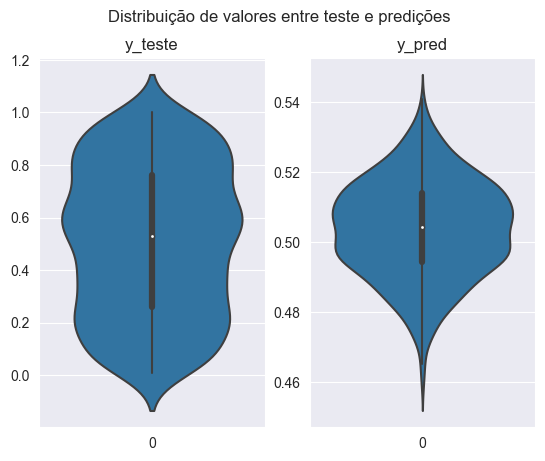

In [21]:
# Plotandoos gráficos
fig, axes = plt.subplots(1, 2)
fig.suptitle('Distribuição de valores entre teste e predições')
sns.violinplot(list(y_teste), ax=axes[0])
axes[0].set_title('y_teste')
sns.violinplot(y_pred, ax=axes[1])
axes[1].set_title('y_pred')

As predições estão bem concentradas entre 0.48 e 0.52, enquanto os dados reais variam bastante. E isso é um problema, pois demonstra que o modelo não conseguiu aprender tão bem assim.

Neste caso, precisaríamos de mais dados para poder produzir uma solução mais eficiente.